<a href="https://colab.research.google.com/github/pragyan2905/Multi-Sectoral-Inflation-Predictor/blob/main/food_price_inflation_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import sklearn as sk

In [12]:
df = pd.read_csv('WLD_RTFP_country_2023-10-02.csv')

In [3]:
df.head()

,Open,High,Low,Close,Inflation,country,ISO3,date
0,0.53,0.54,0.53,0.53,NaN,Afghanistan,AFG,2007-01-01
1,0.53,0.54,0.53,0.53,NaN,Afghanistan,AFG,2007-02-01
2,0.54,0.54,0.53,0.53,NaN,Afghanistan,AFG,2007-03-01
3,0.53,0.55,0.53,0.55,NaN,Afghanistan,AFG,2007-04-01
4,0.56,0.57,0.56,0.57,NaN,Afghanistan,AFG,2007-05-01


In [4]:
df.shape

(4798, 8)

In [13]:
df = df.drop(['Open','High','Low','Close','ISO3'], axis=1)

In [14]:
df.columns

Index(['Inflation', 'country', 'date'], dtype='object')

In [18]:
df_cleaned = df.dropna(subset=['Inflation', 'country', 'date'])

In [19]:
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

In [20]:
df_cleaned['country'] = df_cleaned['country'].str.strip()

In [21]:
df_cleaned.isnull().sum()

,0
Inflation,0
country,0
date,0


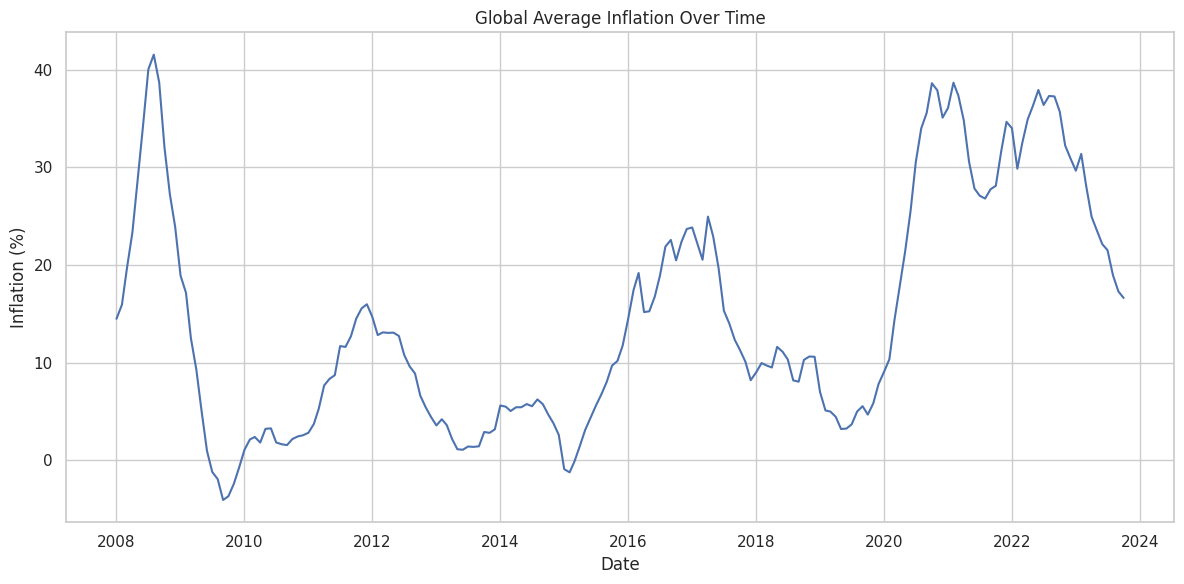

--------------------------------------------------------------------------------------------------------


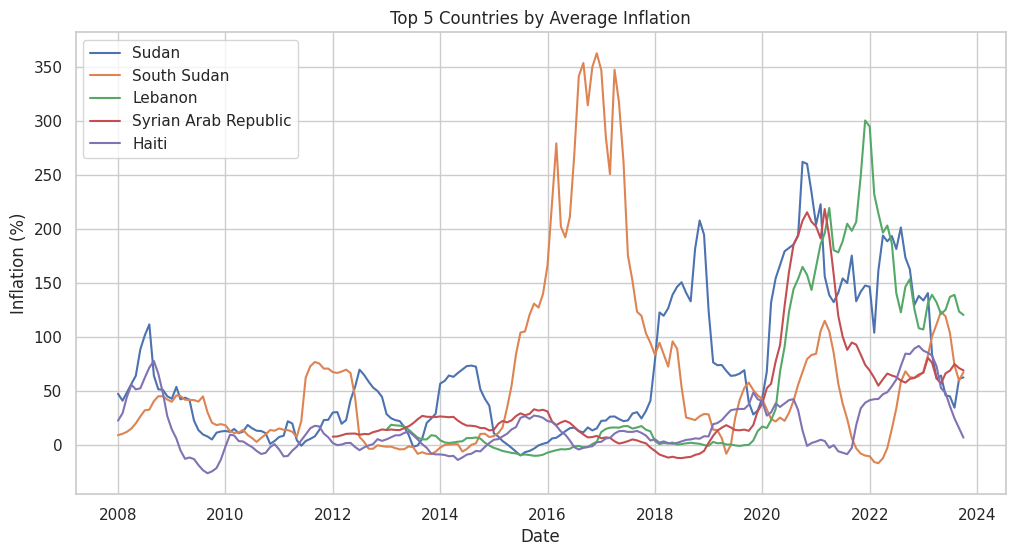

In [25]:

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

global_monthly = df_cleaned.groupby('date')['Inflation'].mean()

plt.plot(global_monthly.index, global_monthly.values)
plt.title('Global Average Inflation Over Time')
plt.xlabel('Date')
plt.ylabel('Inflation (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

print ("-"*104)

top_countries = df_cleaned.groupby('country')['Inflation'].mean().sort_values(ascending=False).head(5).index

for country in top_countries:
    subset = df_cleaned[df_cleaned['country'] == country]
    plt.plot(subset['date'], subset['Inflation'], label=country)

plt.title('Top 5 Countries by Average Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
df_cleaned['year'] = df_cleaned['date'].dt.year
df_cleaned['month'] = df_cleaned['date'].dt.month
df_cleaned['quarter'] = df_cleaned['date'].dt.quarter

df_cleaned['lag_inflation_1'] = df_cleaned.groupby('country')['Inflation'].shift(1)

df_cleaned['rolling_avg_3'] = df_cleaned.groupby('country')['Inflation'].rolling(window=3).mean().reset_index(0, drop=True)

df_cleaned['monthly_change'] = df_cleaned['Inflation'] - df_cleaned['lag_inflation_1']

print(df_cleaned[['country', 'date', 'Inflation', 'lag_inflation_1', 'rolling_avg_3', 'monthly_change', 'month', 'quarter']].head(10))

        country       date  Inflation  lag_inflation_1  rolling_avg_3  \
12  Afghanistan 2008-01-01      41.18              NaN            NaN   
13  Afghanistan 2008-02-01      44.45            41.18            NaN   
14  Afghanistan 2008-03-01      53.62            44.45      46.416667   
15  Afghanistan 2008-04-01      66.52            53.62      54.863333   
16  Afghanistan 2008-05-01      77.51            66.52      65.883333   
17  Afghanistan 2008-06-01      89.19            77.51      77.740000   
18  Afghanistan 2008-07-01      96.05            89.19      87.583333   
19  Afghanistan 2008-08-01      96.79            96.05      94.010000   
20  Afghanistan 2008-09-01      89.86            96.79      94.233333   
21  Afghanistan 2008-10-01      78.44            89.86      88.363333   

    monthly_change  month  quarter  
12             NaN      1        1  
13            3.27      2        1  
14            9.17      3        1  
15           12.90      4        2  
16         

In [27]:
df_model_ready = df_cleaned.dropna().copy()

df_model_ready.reset_index(drop=True, inplace=True)

print("Shape after cleaning:", df_model_ready.shape)
print("\nMissing values:\n", df_model_ready.isnull().sum())
print("\nSample rows:\n", df_model_ready.head())

Shape after cleaning: (4384, 9)

Missing values:
 Inflation          0
country            0
date               0
year               0
month              0
quarter            0
lag_inflation_1    0
rolling_avg_3      0
monthly_change     0
dtype: int64

Sample rows:
    Inflation      country       date  year  month  quarter  lag_inflation_1  \
0      53.62  Afghanistan 2008-03-01  2008      3        1            44.45   
1      66.52  Afghanistan 2008-04-01  2008      4        2            53.62   
2      77.51  Afghanistan 2008-05-01  2008      5        2            66.52   
3      89.19  Afghanistan 2008-06-01  2008      6        2            77.51   
4      96.05  Afghanistan 2008-07-01  2008      7        3            89.19   

   rolling_avg_3  monthly_change  
0      46.416667            9.17  
1      54.863333           12.90  
2      65.883333           10.99  
3      77.740000           11.68  
4      87.583333            6.86  


In [29]:
from sklearn.model_selection import train_test_split

X = df_model_ready.drop(columns=['Inflation', 'country', 'date'])
y = df_model_ready['Inflation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.5 MB/s eta 0:00:00


In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

In [45]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

[I 2025-08-03 17:52:12,956] A new study created in memory with name: no-name-f96a9bce-842f-49f7-84c2-7e3ba875a1d0
[I 2025-08-03 17:52:17,118] Trial 0 finished with value: 97.15969109941345 and parameters: {'lambda': 0.3319111798679072, 'alpha': 0.045778482697591216, 'colsample_bytree': 0.9352294357615786, 'subsample': 0.6471448634698507, 'learning_rate': 0.0012737897102190207, 'n_estimators': 848, 'max_depth': 11, 'min_child_weight': 10}. Best is trial 0 with value: 97.15969109941345.
[I 2025-08-03 17:52:17,302] Trial 1 finished with value: 23.245078503246003 and parameters: {'lambda': 0.07546115281016064, 'alpha': 0.023283936979776734, 'colsample_bytree': 0.458584801003778, 'subsample': 0.5613447922426098, 'learning_rate': 0.010771883923602852, 'n_estimators': 529, 'max_depth': 3, 'min_child_weight': 7}. Best is trial 1 with value: 23.245078503246003.
[I 2025-08-03 17:52:17,731] Trial 2 finished with value: 341.5705183091441 and parameters: {'lambda': 0.025363564731705028, 'alpha': 8.

Best hyperparameters: {'lambda': 1.7585207857665979, 'alpha': 0.04599966932567541, 'colsample_bytree': 0.6189421215115667, 'subsample': 0.5720223003331834, 'learning_rate': 0.2006012065345031, 'n_estimators': 827, 'max_depth': 3, 'min_child_weight': 3}


In [46]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'
best_params['verbosity'] = 0

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)
preds = final_model.predict(X_test)

In [47]:
from sklearn.metrics import mean_absolute_error, r2_score

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("MSE:", mse)
print("MAE:", mae)
print("R² Score:", r2)

MSE: 11.146430838614396
MAE: 0.7687706309520855
R² Score: 0.9876397726445754


In [48]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 3.338627088881655
